In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Project Description

For this project I will use the **New York Electric Grid (NYISO) Data**.

Throughout, I will compute the length of a link as computed using the latitude and longitude of each node (termed 'bus' in the data set).

1. Repeat one million times: take a randomly chosen pair of nodes A and B, and compute the length of a shortest path between them. You can use any library for this purpose. Plot a histogram showing the distribution of lengths.

2. Implement the algorithm for the minimum-cost node tour problem (i.e., the node inspection problem) on this data.  You only need to examine **one** pairing of the odd nodes. You only need to report on the **cost** of your tour, that is to say you do not need to implement the splicing operation.

3. Now repeat step 2, examining *random* pairings of the odd nodes.  Perform this step for at least 1000 pairings.  The TA/CA may ask to perform more.  Report on the best solution you find.

4. Use the 'splicing' algorithm to actually compute the tour itself, for the best solution obtained in Step 3.


# Loading Data


In [ ]:
import pandas as pd
import numpy as np
import networkx as nx
import random
from scipy.spatial.distance import euclidean
import matplotlib.pyplot as plt
from math import radians, sin, cos, sqrt, atan2
from geopy.distance import geodesic
from networkx.algorithms.matching import min_weight_matching

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
nyisobranches = pd.read_csv('/content/drive/My Drive/Optimization Projects/project2/nyisobranches.csv')
nyisobuses = pd.read_csv('/content/drive/My Drive/Optimization Projects/project2/nyisobuses.csv')

In [ ]:
nyisobranches.head(5)

,branch number,first bus number,second bus number
0,1,123,4232
1,2,187,3532
2,3,239,76466
3,4,338,8443
4,5,845,8079


In [ ]:
nyisobuses.head(5)

,Bus Number,Name,Area Name,Latitude,Longitude,Status,# Neighbors (in service only),Nom kV,PU Volt,Volt (kV),...,Gen Min MW,Gen Max MW,Gen Min Mvar,Gen Max Mvar,Switched Shunts Mvar,Switched Shunts Nom Mvar,Max Mvar,Min Mvar,Area Num,Zone Num
0,123,J C McNeil,Vermont,44.492,-73.208,Connected,1,138,0.99773,137.686,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35,1
1,187,9001043100,Connecticut,41.110,-73.457,Connected,1,138,0.99500,137.310,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1
2,239,9001071000,Connecticut,41.172,-73.218,Connected,1,230,1.00859,231.975,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1
3,338,9001245500,Connecticut,41.275,-73.516,Connected,1,138,0.95884,132.319,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1
4,845,9011690300,Connecticut,41.293,-72.925,Connected,1,138,0.98595,136.062,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1


# Q1

In [ ]:
# Build funtion to calculate the distance
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in km
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c

In [ ]:
G = nx.Graph()
# Add nodes with attributes
for _, row in nyisobuses.iterrows():
    G.add_node(row['Bus Number'], pos=(row['Latitude'], row['Longitude']))
# Add edges with Haversine distance as weight
for _, row in nyisobranches.iterrows():
    node1, node2 = row[1], row[2]
    if node1 in G.nodes and node2 in G.nodes:
        lat1, lon1 = G.nodes[node1]['pos']
        lat2, lon2 = G.nodes[node2]['pos']
        distance = haversine(lat1, lon1, lat2, lon2)
        G.add_edge(node1, node2, weight=distance)

<ipython-input-18-c956ad87d5e4>:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  node1, node2 = row[1], row[2]


In [ ]:
# Randomly sample
nodes_list = list(G.nodes)
num_samples = 1000000
random_pairs = random.sample([(a, b) for a in nodes_list for b in nodes_list if a != b], num_samples)

In [ ]:
# Compute shortest paths
distances = []
for node_a, node_b in random_pairs:
    try:
        path_length = nx.shortest_path_length(G, source=node_a, target=node_b, weight='weight', method='dijkstra')
        distances.append(path_length)
    except nx.NetworkXNoPath:
        continue

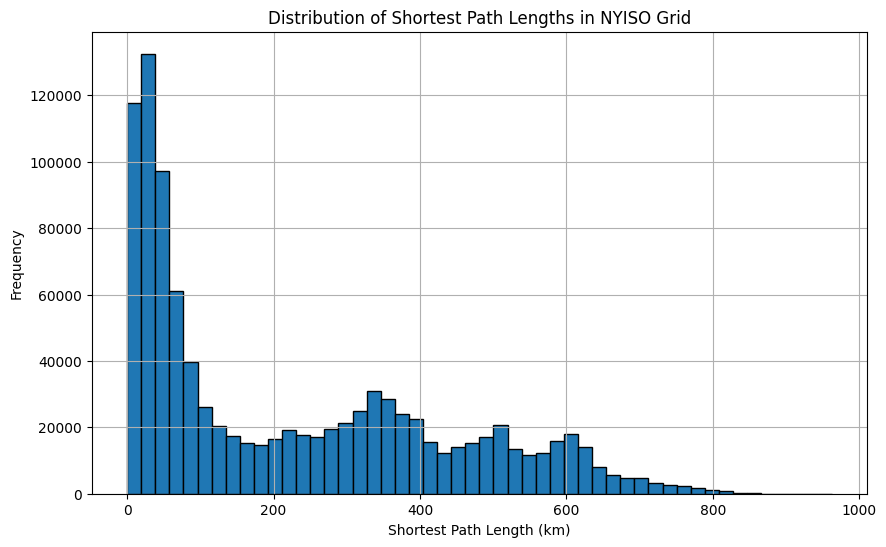

In [ ]:
# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(distances, bins=50, edgecolor='black')
plt.xlabel("Shortest Path Length (km)")
plt.ylabel("Frequency")
plt.title("Distribution of Shortest Path Lengths in NYISO Grid")
plt.grid()
plt.show()

# Q2

In [ ]:
random.seed(42)
# Compute the Minimum Spanning Tree
mst = nx.minimum_spanning_tree(G, weight="weight")

# Identify odd-degree nodes in the MST
odd_degree_nodes = [node for node, degree in mst.degree() if degree % 2 == 1]

# Ensure there are at least two odd-degree nodes
if len(odd_degree_nodes) < 2:
    raise ValueError("Not enough odd-degree nodes to pair.")

# Randomly pair the odd-degree nodes (without slicing)
random.shuffle(odd_degree_nodes)
odd_node_pairs = []

paired_nodes = set()
while len(paired_nodes) < len(odd_degree_nodes):
    available_nodes = [n for n in odd_degree_nodes if n not in paired_nodes]
    if len(available_nodes) < 2:
        break
    u, v = random.sample(available_nodes, 2)  # Pick two nodes randomly
    odd_node_pairs.append((u, v))
    paired_nodes.add(u)
    paired_nodes.add(v)

# The shortest path distance for each pair in the original graph
pair_distances = {}
for u, v in odd_node_pairs:
    try:
        pair_distances[(u, v)] = nx.shortest_path_length(G, source=u, target=v, weight="weight")
    except nx.NetworkXNoPath:
        pair_distances[(u, v)] = float('inf')  # Assign infinite cost if no path exists

# The total tour cost
mst_cost = sum(nx.get_edge_attributes(mst, "weight").values())  # MST total cost
pairing_cost = sum(pair_distances.values())  # Additional cost from pairing odd nodes
total_tour_cost = mst_cost + pairing_cost  # Final Eulerian tour cost

# Output
print(f"Minimum-cost node tour cost (MST + random pairing): {total_tour_cost:.2f} km")
print(f"Randomly paired odd-degree nodes: {odd_node_pairs}")
print(f"MST cost: {mst_cost:.2f} km")
print(f"Pairing cost: {pairing_cost:.2f} km")
print(f"Number of odd-degree nodes:{len(odd_degree_nodes)}")

Minimum-cost node tour cost (MST + random pairing): 83443.76 km
Randomly paired odd-degree nodes: [(8157, 6696), (7444, 3599), (76457, 3433), (7488, 3594), (4507, 6345), (6558, 7976), (77627, 7921), (4651, 7202), (8331, 5416), (6077, 4344), (8480, 5866), (7711, 5928), (4243, 6320), (8345, 7982), (5862, 3503), (8361, 6847), (7796, 8398), (5785, 3943), (77542, 4209), (7287, 77541), (8016, 76702), (5940, 95341), (7164, 7950), (3678, 4051), (5080, 3615), (5736, 76684), (5109, 76518), (5453, 7470), (8430, 3801), (6468, 8225), (7549, 6806), (6277, 3602), (4450, 5719), (8344, 6554), (4902, 5306), (7790, 5628), (8271, 77054), (4951, 9611), (6800, 7914), (3534, 6432), (338, 3654), (7836, 7858), (5607, 7149), (4561, 5215), (76735, 8304), (6899, 8294), (75580, 6063), (6665, 6228), (76517, 4977), (4542, 3531), (95342, 6583), (3581, 4644), (5743, 7612), (6138, 77359), (5201, 8033), (5126, 4729), (3563, 7635), (77426, 8523), (7102, 3846), (4497, 3722), (6249, 5935), (6834, 3738), (77162, 3512), (600

# Q3

In [ ]:
random.seed(42)
# Initialize tracking variables
best_tour_cost = float('inf')  # Keep track of the best tour cost
best_pairing = None  # Store the best pairing found
num_trials = 1000  # Perform 1000 random pairings

# Repeat 1000 times with random pairings
for _ in range(num_trials):
    random.shuffle(odd_degree_nodes)  # Shuffle the list
    odd_node_pairs = []  # Store random pairings

    # Pair nodes randomly
    paired_nodes = set()
    while len(paired_nodes) < len(odd_degree_nodes):
        available_nodes = [n for n in odd_degree_nodes if n not in paired_nodes]
        if len(available_nodes) < 2:
            break  # Stop if there's not enough to form a pair
        u, v = random.sample(available_nodes, 2)  # Pick two nodes randomly
        odd_node_pairs.append((u, v))
        paired_nodes.add(u)
        paired_nodes.add(v)

    # The shortest path distance for each pair in the original graph
    pair_distances = {}
    for u, v in odd_node_pairs:
        try:
            pair_distances[(u, v)] = nx.shortest_path_length(G, source=u, target=v, weight="weight")
        except nx.NetworkXNoPath:
            pair_distances[(u, v)] = float('inf')  # Assign infinite cost if no path exists

    # The total cost of the tour
    mst_cost = sum(nx.get_edge_attributes(mst, "weight").values())  # MST total cost
    pairing_cost = sum(pair_distances.values())  # Additional cost from pairing odd nodes
    total_tour_cost = mst_cost + pairing_cost  # Final Eulerian tour cost

    # Track the best solution
    if total_tour_cost < best_tour_cost:
        best_tour_cost = total_tour_cost
        best_pairing = odd_node_pairs

# The best random pairing solution found
print(f"Best minimum-cost tour cost after {num_trials} trials: {best_tour_cost:.2f} km")
print(f"Best randomly selected odd-degree node pairs: {best_pairing}")

Best minimum-cost tour cost after 1000 trials: 70033.55 km
Best randomly selected odd-degree node pairs: [(8434, 12280), (6283, 3986), (77037, 8767), (9654, 4165), (6834, 95342), (76485, 3846), (6468, 7026), (5516, 338), (5215, 8839), (7100, 4026), (3745, 3581), (4312, 3531), (4977, 8380), (8345, 7149), (4378, 77231), (76462, 7604), (4897, 4274), (8392, 76457), (7609, 5201), (3778, 6007), (8164, 3594), (6939, 8056), (5725, 4753), (4153, 5534), (7329, 5744), (77465, 6923), (4644, 5453), (3556, 3547), (3433, 7858), (8523, 5006), (76476, 3628), (77200, 4172), (7453, 4207), (6244, 6160), (4775, 6067), (5154, 8043), (77541, 7202), (3951, 6725), (7835, 9611), (5087, 6218), (6137, 4675), (77121, 4727), (3718, 4005), (6914, 3613), (8352, 5080), (7061, 77627), (5971, 7261), (7281, 3995), (3549, 77426), (6770, 5815), (7164, 7583), (8157, 5628), (77359, 76491), (7950, 8350), (5157, 4643), (6320, 7808), (7733, 77450), (1761, 77498), (5785, 6188), (6595, 77032), (3997, 6264), (6345, 6228), (1380, 7

# Q4

In [ ]:
eulerian_multigraph = nx.MultiGraph(mst)

for u, v in best_pairing:
    try:
        shortest_path = nx.shortest_path(G, source=u, target=v, weight="weight")

        for i in range(len(shortest_path) - 1):
            u1, v1 = shortest_path[i], shortest_path[i+1]
            eulerian_multigraph.add_edge(u1, v1, weight=G[u1][v1]['weight'])

    except nx.NetworkXNoPath:
        raise ValueError(f"No valid path exists between {u} and {v}. The graph might be disconnected.")


eulerian_tour = list(nx.eulerian_circuit(eulerian_multigraph))
eulerian_tour_cost = sum(eulerian_multigraph[u][v][0]['weight'] for u, v in eulerian_tour)

# Print the final results
print(f"Spliced Eulerian Tour Cost = {eulerian_tour_cost:.2f} km")
print(f"Eulerian Tour (sequence of edges): {eulerian_tour}")


Spliced Eulerian Tour Cost = 70033.55 km
Eulerian Tour (sequence of edges): [(123, 4232), (4232, 4231), (4231, 3610), (3610, 4231), (4231, 3610), (3610, 4231), (4231, 3537), (3537, 4601), (4601, 4607), (4607, 3590), (3590, 4607), (4607, 4601), (4601, 3537), (3537, 4231), (4231, 3537), (3537, 4220), (4220, 4219), (4219, 4220), (4220, 4219), (4219, 3540), (3540, 4221), (4221, 4223), (4223, 76509), (76509, 76428), (76428, 76509), (76509, 4223), (4223, 76509), (76509, 3542), (3542, 3362), (3362, 3542), (3542, 76509), (76509, 4223), (4223, 4221), (4221, 4223), (4223, 4221), (4221, 3540), (3540, 4221), (4221, 3540), (3540, 4219), (4219, 3540), (3540, 4219), (4219, 4220), (4220, 3537), (3537, 4220), (4220, 3537), (3537, 4231), (4231, 3610), (3610, 7638), (7638, 5475), (5475, 7638), (7638, 5475), (5475, 7638), (7638, 5475), (5475, 7638), (7638, 5475), (5475, 7638), (7638, 5475), (5475, 4714), (4714, 4705), (4705, 3594), (3594, 4705), (4705, 4714), (4714, 5475), (5475, 3604), (3604, 6415), (641